In [38]:
# imports
import torch
from DataObjects.DataLoader import DataLoader
from Architectures.Statistical.GMM import GMMClassifier

from pathlib import Path
import numpy as np

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# SETTING SEED
SEED = 42069    
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
# set device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
DATA_PATH = Path("Data")

In [5]:
# prepare Data Loader files
train_dir = DATA_PATH / Path("Fourier_transformed", "training")
val_dir = DATA_PATH / Path("Fourier_transformed", "validation")
test_dir = DATA_PATH / Path("Fourier_transformed", "testing")

batch_size = 64

train_loader = DataLoader(
    data_dir=train_dir,
    data_type='fft',
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    data_dir=val_dir,
    data_type='fft',
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    data_dir=test_dir,
    data_type='fft',
    batch_size=batch_size,
    shuffle=True
)

# Inspect class mapping and dataset size
print("Classes:", train_loader.class_to_idx)
print("# training batches:", len(train_loader))

print("# validation batches:", len(val_loader))

print("# testing batches:", len(test_loader))

Classes: {'bed': 0, 'bird': 1, 'cat': 2, 'dog': 3, 'down': 4, 'eight': 5, 'five': 6, 'four': 7, 'go': 8, 'happy': 9, 'house': 10, 'left': 11, 'marvin': 12, 'nine': 13, 'no': 14, 'off': 15, 'on': 16, 'one': 17, 'right': 18, 'seven': 19, 'sheila': 20, 'silence': 21, 'six': 22, 'stop': 23, 'three': 24, 'tree': 25, 'two': 26, 'up': 27, 'wow': 28, 'yes': 29, 'zero': 30}
# training batches: 587
# validation batches: 216
# testing batches: 211


In [9]:
gmm_model = GMMClassifier(
    n_components=10,
    covariance_type='full',
    max_iter=105,
    random_state=SEED
)

In [10]:
gmm_model.train_architecture(train_loader)

Trained GMMs for classes: [9, 13, 4, 8, 22, 5, 0, 18, 24, 11, 26, 15, 1, 14, 6, 27, 28, 2, 30, 3, 7, 16, 20, 25, 23, 29, 10, 19, 12, 17, 21]


c:\Users\aaf6\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [11]:
results = gmm_model.evaluate(test_loader * 0.2)
print("Test summary:")
for metric, value in results['summary'].items():
    print(f"  {metric}: {value:.4f}")

Test summary:
  loss: 183.1610
  accuracy: 0.1682
  precision: 0.1944
  recall: 0.1693
  f1: 0.1649


## More automated approach to running tests
Running tests throgh an automated Experiment Object created through ExperimentFactory for easy and streamlined experiments.

In [ ]:
from DataObjects.Experiments import ExperimentFactory, GMMClassifier

In [ ]:
# set device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
gmm_exp = ExperimentFactory.create_experiment(
    arch_name='gmm',
    train_dir='Data/Fourier_transformed/training',
    val_dir='Data/Fourier_transformed/validation',
    test_dir='Data/Fourier_transformed/testing',
    batch_size=64,
    save_path = "Saved_experimented_data/GMM_experiment.txt",
    model_kwargs={
        'n_components': 4,
        'covariance_type': 'full',
        'max_iter': 100,
        'random_state': 42
    }
)

In [ ]:
gmm_exp.run()

c:\Users\aaf6\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\aaf6\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\aaf6\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\aaf6\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{}

In [32]:
# Cell 1: imports & device
import os
from pathlib import Path

import torch
import optuna
from optuna.pruners import SuccessiveHalvingPruner
from optuna.trial import TrialState

# Make sure your DataLoader, SimpleCNN, and train_CNN are already defined above this cell!

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cp u')
print(f"Using device: {device}")

# Data paths (reuse your variables)
DATA_PATH = Path("Data")
train_dir = str(DATA_PATH / "Fourier_transformed" / "training")
val_dir   = str(DATA_PATH / "Fourier_transformed" / "validation")


Using device: cuda


In [33]:
def train_GMM(config, device):
    model = GMMClassifier(
        max_iter=30,
        random_state=SEED,
        n_components=config["n_components"],
        covariance_type=config["covariance_type"],
    )

    train_loader = DataLoader(
        data_dir=config["train_dir"],
        data_type='fft',
        batch_size=config["batch_size"],
        shuffle=True
    )
    val_loader = DataLoader(
        data_dir=config["val_dir"],
        data_type='fft',
        batch_size=config["batch_size"],
        shuffle=True
    )

    model.train_architecture(train_loader=train_loader)
    results = model.evaluate(val_loader)

    final_loss = results["summary"]["loss"]
    final_acc  = results["summary"]["accuracy"]
    return final_loss, final_acc


In [36]:
def objective(trial):
    # 1) sample hyperparameters
    config = {
        "n_components":         trial.suggest_categorical("n_components", [2 ,6, 8, 12, 20]),
        "covariance_type":     trial.suggest_categorical("covariance_type", ["full", "spherical"]),
        "batch_size": 32,
        "train_dir":  train_dir,
        "val_dir":    val_dir,
    }

    # initialize, train, and evaluate your model
    final_loss, final_acc = train_GMM(config, device)
    return final_acc


In [37]:
# Cell 3: create & run the study
pruner = SuccessiveHalvingPruner(
    min_resource=1,          # minimum epochs before pruning
    reduction_factor=2,      # cut half the trials each round
    min_early_stopping_rate=1
)

study = optuna.create_study(
    direction="maximize",
    pruner=pruner
)

# run 10 trials
study.optimize(objective, n_trials=10)


[I 2025-04-29 07:13:48,062] A new study created in memory with name: no-name-1a1db276-be64-4aad-92d8-20f4fd51f4a8
c:\Users\aaf6\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Trained GMMs for classes: [20, 22, 14, 16, 1, 23, 25, 28, 11, 9, 13, 26, 30, 15, 8, 17, 24, 5, 0, 18, 7, 4, 6, 19, 12, 10, 3, 29, 27, 2, 21]


[I 2025-04-29 07:50:36,621] Trial 0 finished with value: 0.15219285506825442 and parameters: {'n_components': 20, 'covariance_type': 'full'}. Best is trial 0 with value: 0.15219285506825442.
c:\Users\aaf6\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
c:\Users\aaf6\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
c:\Users\aaf6\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
[W 2025-04-29 07:50:51,725

ValueError: Fitting the mixture model failed because some components have ill-defined empirical covariance (for instance caused by singleton or collapsed samples). Try to decrease the number of components, or increase reg_covar.

In [ ]:
# Cell 4: examine results
from optuna.trial import TrialState
import pandas as pd

# summary
trials = study.trials
n_complete = len([t for t in trials if t.state is TrialState.COMPLETE])
n_pruned   = len([t for t in trials if t.state is TrialState.PRUNED])
print(f"Finished {len(trials)} trials: {n_complete} complete, {n_pruned} pruned")

# best trial
best = study.best_trial
print(f"\nBest accuracy: {best.value:.4f}")
print("Params:")
for k, v in best.params.items():
    print(f"  {k}: {v}")

# optional: dataframe of all trials
df = study.trials_dataframe()
df


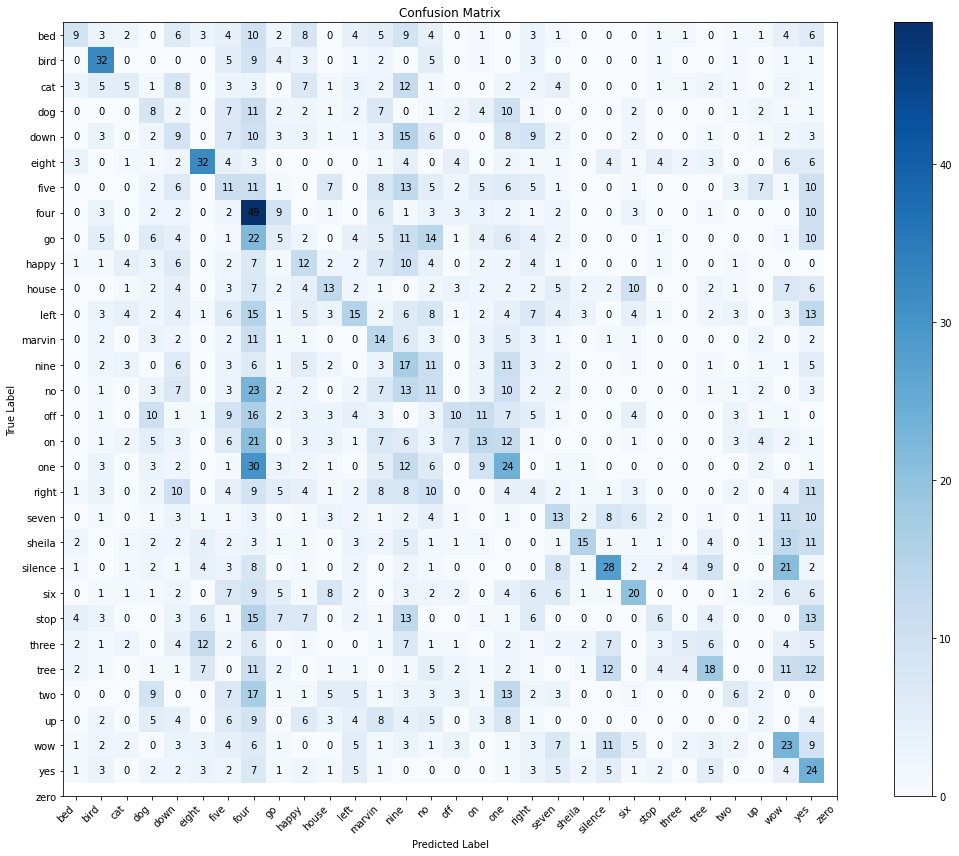

In [39]:
cm = results['confusion_matrix']
labels = list(train_loader.class_to_idx.keys())

fig, ax = plt.subplots(figsize=(20, 12))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues', vmin=0, vmax=cm.max())

ax.set(
    xticks=np.arange(len(labels)),
    yticks=np.arange(len(labels)),
    xticklabels=labels,
    yticklabels=labels,
    xlabel='Predicted Label',
    ylabel='True Label',
    title='Confusion Matrix'
)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]:d}", ha='center', va='center')

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.tight_layout()
plt.show()
